We will create a risk score for each tool based on:
1. Days Since Last Calibration (Older tools = Higher risk)
2. Anomaly Score (Autoencoder flagged anomalies = Higher risk)
3. Months Remaining Before Calibration (Less time left = Higher risk)

In [1]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load processed dataset
df = pd.read_csv("Processed_Bosch_Dataset.csv")

In [3]:
# Load scaler from EDA to ensure consistency (if needed for additional scaling)
scaler = joblib.load("scaler.pkl")

In [4]:
# Ensure Autoencoder anomaly scores are included
if "Anomaly_Score_AE" not in df.columns:
    anomalies_df = pd.read_csv("Detected_Anomalies_Autoencoder.csv")
    df = df.merge(anomalies_df[["Tool_Description", "Anomaly_Score_AE"]], on="Tool_Description", how="left")

In [5]:
df["Anomaly_Score_AE"] = df["Anomaly_Score_AE"].fillna(0)  # Ensure no missing values

In [6]:
print("\n Successfully loaded data with anomaly scores!")


 Successfully loaded data with anomaly scores!


We will use a weighted scoring system to determine risk levels:

*   40% → Days Since Last Calibration (Older tools = Higher risk)
*   30% → Months Remaining Before Next Calibration (Less time left = Higher risk)

*   30% → Anomaly Score (If flagged as an anomaly, higher risk)

In [7]:
# Define Risk Score Formula (Weighted Factors)
df["Risk_Score"] = (
    (df["Days_Since_Last_Calibration"] / df["Days_Since_Last_Calibration"].max()) * 0.4 +  # Weight 40%
    (df["Months_Remaining"].apply(lambda x: 1 - (x / df["Months_Remaining"].max()))) * 0.3 +  # Weight 30%
    (df["Anomaly_Score_AE"] * 0.3)  # Weight 30%
)

In [8]:
# Normalize Risk Score (0 to 100 Scale)
df["Risk_Score"] = df["Risk_Score"] * 100

In [9]:
# Save Risk Scores
df.to_csv("Compliance_Risk_Scores.csv", index=False)

In [10]:
print("\n Compliance Risk Scores Generated & Saved!")


 Compliance Risk Scores Generated & Saved!


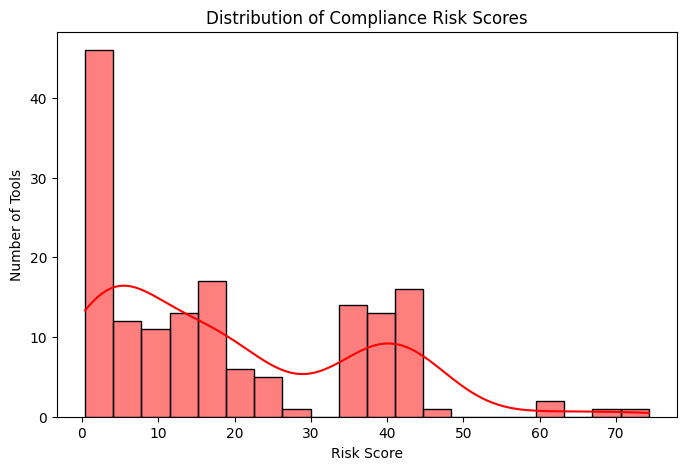

In [11]:
# Histogram of Risk Scores
plt.figure(figsize=(8,5))
sns.histplot(df["Risk_Score"], bins=20, kde=True, color="red")
plt.title("Distribution of Compliance Risk Scores")
plt.xlabel("Risk Score")
plt.ylabel("Number of Tools")
plt.show()

In [12]:
# Highlight High-Risk Tools
df_high_risk = df[df["Risk_Score"] > 70]  # Tools with high risk
print(f"\n🔹 High-Risk Tools Identified: {len(df_high_risk)}")


🔹 High-Risk Tools Identified: 1


In [13]:
# Print High-Risk Tool Details
print("\n High-Risk Tool Details:\n")
print(df_high_risk[["Tool_Description", "Days_Since_Last_Calibration", "Months_Remaining", "Anomaly_Score_AE", "Risk_Score"]])


 High-Risk Tool Details:

            Tool_Description  Days_Since_Last_Calibration  Months_Remaining  \
88  Tachometer (non-contact)                     0.634489          0.370265   

    Anomaly_Score_AE  Risk_Score  
88               1.0   74.271614  


In [14]:
# Adjusted Threshold for High-Risk Tools
df_high_risk = df[df["Risk_Score"] > 50]
print(f"\n🔹 Adjusted High-Risk Tools Identified: {len(df_high_risk)}")


🔹 Adjusted High-Risk Tools Identified: 4


In [15]:
# Save High-Risk Tools for Report Generation
df_high_risk.to_csv("High_Risk_Tools.csv", index=False)
print("\n High-Risk Tools Saved for Report Generation!")


 High-Risk Tools Saved for Report Generation!
